# Modeling Notebook

Authors: Dan Powell, Melissa Messervy, Matthew Johnescu

In [ ]:
# Matt - Light Gradient Boosting Machine - open-source machine learning framework that uses decision trees to perform classification, ranking, and other tasks.(https://github.com/microsoft/LightGBM)
# Dan Powell - SVM
# Melissa - Logistic Regression

# Table of Contents:
- [Introduction](#introdution)
- [Loading Packages](#loading-packages)
- [Loading Data](#loading-data)
- [Cleaning Data](#cleaning-data)
- [LightGBM Model](#lightgbm-model)
  - [Prepping Model](#prepping-model)
  - [Running Model with Cross-Validation](#runnig-model-with-cross-validation)
  - [Early Stopping](#early-stopping)
  - [Plotting Feature Importance](#plotting-feature-importance)
  - [Adjusting for Class Imbalance](#adjusting-for-class-imbalance)
  - [Re-Train Model with Updated Parameters](#re-train-model-with-updated-parameters)
  - [Non-Kaggle Evaluation Score](#non-kaggle-evaluation-score)
  - [LightGBM Conclusions](#lightgbm-conclusions)

- [Support Vector Machine](#support-vector-machine)
  - [Feature Selection and SVM Data Preparation](#feature-selection-and-svm-model-preparation)
  - [Simple Linear Model](#simple-linear-model)
    - [Simple 3-Fold Cross Validation with Linear SVM Model](simple3-fold-cross-validation-with-linear-svm-model)
    - [SMOTE Linear SVM Model](smote-linear-svm-model)
  - [Test Data](test-data)
  - [SVM Conclusions](svm-conclusions)


# Introduction
This notebook aims to develop a predictive model to determine loan repayment ability for individuals with limited or no traditional credit history, addressing Home Credit's challenge of serving underserved populations. By utilizing alternative data sources such as telco and transactional information, we aim to enhance the loan approval process, minimize defaults, and expand access to responsible credit.

The goal is to increase loan approval rates for creditworthy individuals, reduce default rates, and broaden financial inclusion while providing optimized loan terms. These improvements will help Home Credit expand its client base responsibly and increase profitability.

The notebook explores supervised machine learning techniques, focusing on classification models to predict loan default probability using both traditional and alternative data. The main performance metric is the Area Under the ROC Curve (AUC-ROC), along with metrics like increased loan approvals and reduced defaults.

We will compare the performance of Light Gradient Boosting Machine (LightGBM), Support Vector Machine (SVM), and Logistic Regression models to identify the best approach. Issues such as class imbalance, cross-validation, and feature importance are addressed to ensure a robust and accurate final model.

By combining these approaches, this notebook aims to improve loan approval accuracy and support Home Credit's mission to expand responsible access to credit.

# Loading Packages



In [ ]:
#packages
library(dplyr)
install.packages("caret")
library(caret)
library(pROC)
install.packages('kernlab')
library(kernlab)

# This will take like 7 minutes to install, feel free to comment out or temp remove when working
#install.packages("lightgbm", repos = "https://cloud.r-project.org")
#library(lightgbm)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: ggplot2

Loading required package: lattice

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘kernlab’


The following object is masked from ‘package:ggplot2’:

    alph

# Loading Data

In [ ]:
#load in training and test data

train_data <- read.csv('/content/application_train.csv', stringsAsFactors = TRUE)
test_data <- read.csv('/content/application_test.csv')
cleanedTrainData <- train_data

# Cleaning Data

In [ ]:
set.seed(123)
# Function to clean data
clean_data <- function(data) {
  # Get list of all factor columns
  factor_cols <- names(data)[sapply(data, is.factor)]
  print(factor_cols)
  # Replace the null values with a value of "missing"
  data[factor_cols][is.na(data[factor_cols])] <- "missing"
  data$isCashLoan <- ifelse(data$NAME_CONTRACT_TYPE %in% c("Cash loans"), 1, 0)
  # Convert married to new column that includes 1 if in married or civil marriage and 0 otherwise
  data$isMarried <- ifelse(data$NAME_FAMILY_STATUS %in% c("Married", "Civil marriage"), 1, 0)
  # Creating variable for more than secondary education
  data$morethanSecondaryEd <- ifelse(data$NAME_EDUCATION_TYPE %in% c("Higher education", "Incomplete higher", "Academic degree"), 1, 0)
  # Creating variable for secondary or lower education
  data$SecondaryorLowerEd <- ifelse(data$NAME_EDUCATION_TYPE %in% c("Secondary / secondary special", "Lower secondary"), 1, 0)
  #making factor column for isCashLoan
  # Create an anomalous group - where days employed exceeds 100 years
  data$DAY_EMPLOYED_ANOM <- ifelse(data$DAYS_EMPLOYED >= 36500, 1, 0)
  # Remove the anomalous groups from the data
  data$DAYS_EMPLOYED[data$DAYS_EMPLOYED > 36500] <- NA
  # Create column for years old instead of days old for readability
  data$YearsOld <- data$DAYS_BIRTH / -365
  # Divide the age data in bins for every 10 years
  data$age_group <- cut(
    data$YearsOld,
    breaks = seq(min(data$YearsOld, na.rm = TRUE), max(data$YearsOld, na.rm = TRUE), by = 10),
    labels = as.character(seq(round(min(data$YearsOld, na.rm = TRUE),0), round((max(data$YearsOld, na.rm = TRUE) - 10),0) , by = 10)),
    include.lowest = TRUE
  )
  data$age_group <- as.factor(ifelse(is.na(data$age_group), "age_group_missing", data$age_group))
  return(data)
}

# Clean train and test data
cleanedTrainData <- clean_data(train_data)
cleanedTestData <- clean_data(test_data)

 [1] "NAME_CONTRACT_TYPE"         "CODE_GENDER"               
 [3] "FLAG_OWN_CAR"               "FLAG_OWN_REALTY"           
 [5] "NAME_TYPE_SUITE"            "NAME_INCOME_TYPE"          
 [7] "NAME_EDUCATION_TYPE"        "NAME_FAMILY_STATUS"        
 [9] "NAME_HOUSING_TYPE"          "OCCUPATION_TYPE"           
[11] "WEEKDAY_APPR_PROCESS_START" "ORGANIZATION_TYPE"         
[13] "FONDKAPREMONT_MODE"         "HOUSETYPE_MODE"            
[15] "WALLSMATERIAL_MODE"         "EMERGENCYSTATE_MODE"       
character(0)


In [ ]:
#summary(cleanedTrainData)
table(cleanedTrainData$age_group)


                1                 2                 3                 4 
            49044             82770             75458             67945 
age_group_missing 
            32294 

# LightGBM Model

## Prepping Model

In [ ]:
# Set seed for reproducibility
set.seed(123)

# Split training data into training and validation sets (New Step: Splitting Data for Evaluation)
trainIndex <- createDataPartition(cleanedTrainData$TARGET, p = 0.8, list = FALSE)
trainSet <- cleanedTrainData[trainIndex, ]
validationSet <- cleanedTrainData[-trainIndex, ]

# Define the target variable and feature columns
target_variable <- "TARGET"
features <- setdiff(names(cleanedTrainData), target_variable)

# Prepare data for LightGBM
train_matrix <- lgb.Dataset(data = as.matrix(trainSet[, features]), label = trainSet[, target_variable], free_raw_data = FALSE)
validation_matrix <- lgb.Dataset(data = as.matrix(validationSet[, features]), label = validationSet[, target_variable], free_raw_data = FALSE)

# Set parameters for LightGBM
params <- list(
  objective = "binary",
  boosting_type = "gbdt",
  num_leaves = 31,
  learning_rate = 0.05,
  feature_fraction = 0.9
)


## Running Model with Cross Validation

In [ ]:
# Cross-Validation
cv_results <- lgb.cv(params = params, data = train_matrix, nrounds = 500, nfold = 5, stratified = TRUE, eval = "auc", verbose = -1)
print(cv_results)

## Early Stopping

In [ ]:
# Early Stopping
lgb_model <- lgb.train(params = params, data = train_matrix, nrounds = 500, valids = list(validation = validation_matrix), early_stopping_rounds = 100, verbose = -1)


In [ ]:
print(lgb_model)

## Plotting Feature Importance

In [ ]:
# Feature Importance Plot
importance <- lgb.importance(lgb_model)
lgb.plot.importance(importance, top_n = 20)

## Adjusting for the class Imbalance

In [ ]:
# Address Class Imbalance
params$scale_pos_weight <- sum(trainSet$TARGET == 0) / sum(trainSet$TARGET == 1)

This may help performance becuase of the large imbalance in classes found in EDA

## Re-train model with updated parameters



In [ ]:
# Set seed for reproducibility
set.seed(123)
# Re-train model with updated parameters
lgb_model <- lgb.train(params = params, data = train_matrix, nrounds = cv_results$best_iter, valids = list(validation = validation_matrix), early_stopping_rounds = 50, verbose = -1)


Updating and running model based on conclusions from tryong different model levers

Implemented early stopping

## Non-Kaggle Evaluation Score

In [ ]:
# Evaluation Metrics (New Step: Evaluation Metrics)
roc_auc <- roc(validationSet$TARGET, predict(lgb_model, as.matrix(validationSet[, features])))$auc
cat("ROC AUC: ", roc_auc, "\n")

# Confusion Matrix (New Step: Confusion Matrix)
predicted_classes <- ifelse(predict(lgb_model, as.matrix(validationSet[, features])) > 0.5, 1, 0)
conf_matrix <- table(Predicted = predicted_classes, Actual = validationSet$TARGET)
print(conf_matrix)

This is slightly different than Kaggle but represents the accuracy for this particular seed

## Get Kaggle Submission Score

In [ ]:
# Ensure both training and test data have consistent feature sets
features_in_test <- intersect(features, names(cleanedTestData))
missing_features <- setdiff(features, features_in_test)
for (feature in missing_features) {
  cleanedTestData[[feature]] <- 0
}

test_matrix <- as.matrix(cleanedTestData[, features])
# Make predictions on the test set
predictions <- predict(lgb_model, test_matrix)

# Load sample submission file
sample_submission <- read.csv('/content/sample_submission.csv')

# Add predictions to the sample submission
sample_submission$TARGET <- predictions

# Save the updated submission file
write.csv(sample_submission, '/content/submissionlgbm5.csv', row.names = FALSE)

cat("Number of rows in predictions: ", length(predicted_classes), "\n")
cat("Number of rows in sample submission: ", nrow(sample_submission.csv), "\n")


In [ ]:


# Ensure both training and test data have consistent feature sets
features_in_test <- intersect(features, names(cleanedTestData))
missing_features <- setdiff(features, features_in_test)
for (feature in missing_features) {
  cleanedTestData[[feature]] <- 0
}

test_matrix <- as.matrix(cleanedTestData[, features])
# Make predictions on the test set
predictions <- predict(lgb_model, test_matrix)

# Load sample submission file
sample_submission <- read.csv('/content/sample_submission.csv')

# Add predictions to the sample submission
sample_submission$TARGET <- predictions

# Save the updated submission file
write.csv(sample_submission, '/content/submissionlgbm5.csv', row.names = FALSE)


**Results:**
- FIRST SUBMISSION SCORE: 0.73977
- SECOND SUBMISSION SCORE: 0.68161
- THIRD SUBMISSION SCORE: 0.73631
- FOURTH SUBMISSION SCORE: 0.74085

# Support Vector Machine (My Section)

The next model we will use is support vector machine. We chose this method as SVM supports predicting binary outcomes and can be effective in high dimensional spaces. Additionally, SVM models can be robust to overfitting since they focus on a subset of datapoints (support vectors) to define the decision boundary. This can reduce overfitting, which a high-dimensional model can be prone to. Finally, we chose SVM since it can handle imbalanced data. Our dataset is imbalanced, with only ~8% of our observations in our training dataset being a default.

Here, we will run a few models. First, we will run a model using the top 10 most postively and negatively correlated values with a simple linear SVM. We will then use evaluation metrics such as percision, recall and F1 score; and a confusion matrix to identify if and how we can improve the model.

## Feature Selection and SVM Data Preparation

In [ ]:
nullandcorrDF <- sapply(cleanedTrainData, function(column) {
  if (is.numeric(column)) {
    # Calculate percent of nulls
    percent_nulls <- mean(is.na(column)) * 100

    # Calculate correlation with target, excluding NAs
    correlation <- cor(cleanedTrainData$TARGET, column, use = "complete.obs")

    return(c(Percent_Nulls = percent_nulls, Correlation_with_Target = correlation))
  } else {
    return(c(Percent_Nulls = NA, Correlation_with_Target = NA))
  }
})

# Transpose to make it easier to read, then convert to data frame
nullandcorrDF <- as.data.frame(t(nullandcorrDF))

# Order by absolute value of correlation and then by least nulls
ordered_results <- nullandcorrDF %>%
  filter(!is.na(Correlation_with_Target)) %>%
  filter(Percent_Nulls <= 0.1, (Correlation_with_Target >= .01 | Correlation_with_Target <= -.01)) %>%
  arrange(Percent_Nulls, desc(abs(Correlation_with_Target)))
rownames<- rownames(ordered_results)
ordered_results

,Percent_Nulls,Correlation_with_Target
,<dbl>,<dbl>
TARGET,0.0000000000,1.00000000
DAYS_BIRTH,0.0000000000,0.07823931
YearsOld,0.0000000000,-0.07823931
REGION_RATING_CLIENT_W_CITY,0.0000000000,0.06089267
REGION_RATING_CLIENT,0.0000000000,0.05889901
morethanSecondaryEd,0.0000000000,-0.05339135
SecondaryorLowerEd,0.0000000000,0.05339135
DAYS_ID_PUBLISH,0.0000000000,0.05145717
REG_CITY_NOT_WORK_CITY,0.0000000000,0.05099446


## Simple Linear Model

Next, we split our data into training and test groups.

In [ ]:
#creating top 10 and bottom 10 correlated variable dataset
top20train <- cleanedTrainData[c(rownames, 'age_group')]
top20test <- cleanedTestData[c(rownames[-1], 'age_group')]
summary(top20train)

     TARGET          DAYS_BIRTH        YearsOld     REGION_RATING_CLIENT_W_CITY
 Min.   :0.00000   Min.   :-25229   Min.   :20.52   Min.   :1.000              
 1st Qu.:0.00000   1st Qu.:-19682   1st Qu.:34.01   1st Qu.:2.000              
 Median :0.00000   Median :-15750   Median :43.15   Median :2.000              
 Mean   :0.08073   Mean   :-16037   Mean   :43.94   Mean   :2.032              
 3rd Qu.:0.00000   3rd Qu.:-12413   3rd Qu.:53.92   3rd Qu.:2.000              
 Max.   :1.00000   Max.   : -7489   Max.   :69.12   Max.   :3.000              
                                                                               
 REGION_RATING_CLIENT morethanSecondaryEd SecondaryorLowerEd DAYS_ID_PUBLISH
 Min.   :1.000        Min.   :0.0000      Min.   :0.0000     Min.   :-7197  
 1st Qu.:2.000        1st Qu.:0.0000      1st Qu.:0.0000     1st Qu.:-4299  
 Median :2.000        Median :0.0000      Median :1.0000     Median :-3254  
 Mean   :2.052        Mean   :0.2774      Mean   :0.

To prepare the data, we first omit any nulls. As our variables were chosen not to have any nulls or, at least, a small percentage of nulls, we should not have too many rows removed on this step.

We then one-hot encode our categorical variables, which in this case is just the age_group. We then rename these columns to be more intuitive.

Next, we encode the target variable to be a "Y" or "N" value in order to make performance metrics such as confusion matrices easier to read in the future. After which, we factor the target variable to make it compatible with our SVM model.

Finally, we scale our factors to ensure that the magnitude in our variables does not influence their significance to the model. After all of this is complete, we then divide our data into training and test sets.

In [ ]:
#prepare data for SVM
SVMPrepare <- function(data){
  preProc <- preProcess(data, method = "medianImpute")
  data <- predict(preProc, data)
  # Define the one-hot encoding model
  dummies_model <- dummyVars(~ age_group, data = data)


  # Apply the model to create one-hot encoded variables
  data_one_hot <- predict(dummies_model, newdata = data)
  data_one_hot <- cbind(data, data_one_hot)
  #drop original age group column
  data_one_hot <- subset(data_one_hot, select = -age_group)
  #rename columns
  return (data_one_hot)}
  #apply function to training and test for similar datasets
  SVMTrainData <- SVMPrepare(top20train)
  SVMTestData <- SVMPrepare(top20test)
  #rename columns for easier calls
  SVMTrainData <- SVMTrainData %>%
    rename( 'age_group_20_30' = 'age_group.1' ,  'age_group_30_40' = 'age_group.2'
  , 'age_group_40_50' = 'age_group.3' ,  'age_group_50_60' = 'age_group.4')
  SVMTestData <- SVMTestData %>%
  rename( 'age_group_20_30' = 'age_group.1' ,  'age_group_30_40' = 'age_group.2'
  , 'age_group_40_50' = 'age_group.3' ,  'age_group_50_60' = 'age_group.4')
print(names(SVMTestData))
print(names(SVMTrainData))



 [1] "DAYS_BIRTH"                  "YearsOld"                   
 [3] "REGION_RATING_CLIENT_W_CITY" "REGION_RATING_CLIENT"       
 [5] "morethanSecondaryEd"         "SecondaryorLowerEd"         
 [7] "DAYS_ID_PUBLISH"             "REG_CITY_NOT_WORK_CITY"     
 [9] "DAY_EMPLOYED_ANOM"           "FLAG_EMP_PHONE"             
[11] "REG_CITY_NOT_LIVE_CITY"      "FLAG_DOCUMENT_3"            
[13] "DAYS_REGISTRATION"           "REGION_POPULATION_RELATIVE" 
[15] "LIVE_CITY_NOT_WORK_CITY"     "isCashLoan"                 
[17] "AMT_CREDIT"                  "FLAG_DOCUMENT_6"            
[19] "FLAG_WORK_PHONE"             "HOUR_APPR_PROCESS_START"    
[21] "FLAG_PHONE"                  "CNT_CHILDREN"               
[23] "isMarried"                   "FLAG_DOCUMENT_16"           
[25] "FLAG_DOCUMENT_13"            "DAYS_LAST_PHONE_CHANGE"     
[27] "AMT_ANNUITY"                 "AMT_GOODS_PRICE"            
[29] "age_group_20_30"             "age_group_30_40"            
[31] "age_group_40_50"   

In [ ]:
#continue with data preparation by scaling relevant variables and factoring target variables
SVMPrepareCont <- function(data, test) {
  print(names(data))
  if (test == "N"){
  data$TARGET[ data$TARGET == 1] <- "Y"
  data$TARGET[ data$TARGET == 0] <- "N"
  data$TARGET <- as.factor(data$TARGET)}
  data <- data %>%
    mutate_at(vars(-TARGET, -age_group_20_30,  -age_group_30_40,  -age_group_40_50, -age_group_50_60, -age_group.age_group_missing,
  -isCashLoan, -SecondaryorLowerEd, -FLAG_DOCUMENT_6, -FLAG_DOCUMENT_13, -FLAG_DOCUMENT_16, -FLAG_DOCUMENT_3, -FLAG_EMP_PHONE, -isMarried, -LIVE_CITY_NOT_WORK_CITY, -REG_CITY_NOT_LIVE_CITY, -morethanSecondaryEd), scale)
  return (data)
}

  SVMTrainData <- SVMPrepareCont(SVMTrainData ,"N")
  SVMTestData <- SVMTestData %>%
    mutate_at(vars( -age_group_20_30,  -age_group_30_40,  -age_group_40_50, -age_group_50_60, -age_group.age_group_missing,
  -isCashLoan, -SecondaryorLowerEd, -FLAG_DOCUMENT_6, -FLAG_DOCUMENT_13, -FLAG_DOCUMENT_16, -FLAG_DOCUMENT_3, -FLAG_EMP_PHONE, -isMarried, -LIVE_CITY_NOT_WORK_CITY, -REG_CITY_NOT_LIVE_CITY, -morethanSecondaryEd), scale)


  # Create train/test split on train data to evaluate model performance
  train_indices <- createDataPartition(SVMTrainData$TARGET, p = 0.8, list = FALSE)

  # Create train and test datasets
  SVMtrain_data <- SVMTrainData[train_indices, ]
  SVMtest_data <- SVMTrainData[-train_indices, ]

 [1] "TARGET"                      "DAYS_BIRTH"                 
 [3] "YearsOld"                    "REGION_RATING_CLIENT_W_CITY"
 [5] "REGION_RATING_CLIENT"        "morethanSecondaryEd"        
 [7] "SecondaryorLowerEd"          "DAYS_ID_PUBLISH"            
 [9] "REG_CITY_NOT_WORK_CITY"      "DAY_EMPLOYED_ANOM"          
[11] "FLAG_EMP_PHONE"              "REG_CITY_NOT_LIVE_CITY"     
[13] "FLAG_DOCUMENT_3"             "DAYS_REGISTRATION"          
[15] "REGION_POPULATION_RELATIVE"  "LIVE_CITY_NOT_WORK_CITY"    
[17] "isCashLoan"                  "AMT_CREDIT"                 
[19] "FLAG_DOCUMENT_6"             "FLAG_WORK_PHONE"            
[21] "HOUR_APPR_PROCESS_START"     "FLAG_PHONE"                 
[23] "CNT_CHILDREN"                "isMarried"                  
[25] "FLAG_DOCUMENT_16"            "FLAG_DOCUMENT_13"           
[27] "DAYS_LAST_PHONE_CHANGE"      "AMT_ANNUITY"                
[29] "AMT_GOODS_PRICE"             "age_group_20_30"            
[31] "age_group_30_40"   

### Simple 3-Fold Cross Validation with Linear SVM Model

To begin our analysis, we first run a 5-fold-cross-validated SVM model on our target variable and predictors. We use a probability threshold of .5 to make our predictions, as this is usually the default value. At this stage, we are simply seeing how a basic model performs and then making further adjustments after we gather our findings.

In [ ]:
#randomly sample 5000 observations to allow for optimal performance
SVMtrain_data <- SVMtrain_data[sample(nrow(SVMtrain_data), 5000), ]

In [ ]:

train_control <- trainControl(method = "cv", number = 5, classProbs = TRUE, summaryFunction = twoClassSummary)

#fit SVM Model with cross validation
svm_model1 <- train(TARGET ~ .,
                      data = SVMtrain_data,
                      method = "svmLinear",
                      trControl = train_control,
                      probability = TRUE)
#predict using our first simple svmLinear model using the test data
predictions <- predict(svm_model1, newdata = SVMtest_data, type = "prob")$Y
#keep the threshold at 0.5 for now so we can see how the model behaves with a "default" value
binary_predictions <- ifelse(predictions > 0.5, "Y", "N")

#run and output confusion matrix
confusion <- confusionMatrix(factor(binary_predictions), factor(SVMtest_data$TARGET), positive = "Y")
print(confusion)

# get percision from our confusion matrix
precision <- confusion$byClass['Pos Pred Value']
cat('\nPercision: ', precision)

# recall
recall <- confusion$byClass['Sensitivity']
cat('\nRecall: ', recall)

# calculating f1 score from percision and recall
f1_score <- 2 * (precision * recall) / (precision + recall)
cat("\nF1 Score: ", round(f1_score,4))
#beep(sound = 1)

Warning message in train.default(x, y, weights = w, ...):
“The metric "Accuracy" was not in the result set. ROC will be used instead.”


maximum number of iterations reached 0.0019477 0.001926413maximum number of iterations reached 0.003798463 0.00370348maximum number of iterations reached 0.001442454 0.001431858maximum number of iterations reached 0.006856556 0.006563036maximum number of iterations reached 0.004394392 0.004253748maximum number of iterations reached 0.002436295 0.002391624

Warning message in confusionMatrix.default(factor(binary_predictions), factor(SVMtest_data$TARGET), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction     N     Y
         N 56537  4965
         Y     0     0
                                          
               Accuracy : 0.9193          
                 95% CI : (0.9171, 0.9214)
    No Information Rate : 0.9193          
    P-Value [Acc > NIR] : 0.5038          
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.00000         
            Specificity : 1.00000         
         Pos Pred Value :     NaN         
         Neg Pred Value : 0.91927         
             Prevalence : 0.08073         
         Detection Rate : 0.00000         
   Detection Prevalence : 0.00000         
      Balanced Accuracy : 0.50000         
                                          
       'Positive' Class : Y               
                  

### SMOTE Linear SVM Model

While our SVM Model seemed to perfrom well for accuracy, this is primarily due to class imbalance, which can be observed through our non-existant F1 score. Currently, the model just predicts that all observations will be Non-Defaults. However, this is not a good model to use as it does not achieve the goal of identifying potential defaults at all. To rectify this, we will use smote to balance the classes and then try rerunning the linear model.

In [ ]:
#Load performance estimation for smote dataset creation
install.packages("performanceEstimation", repos = "https://cloud.r-project.org")
library(performanceEstimation)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘BBmisc’, ‘checkmate’, ‘parallelMap’




In [ ]:
set.seed(123)


print('Before Smote:\n')
print(table(SVMtrain_data$TARGET))

#ensure datatypes are correct for SMOTE
SVMtrain_data <- data.frame(lapply(SVMtrain_data, function(x) {
  if (is.character(x)) {
    print(x)
  } else {
    x
  }
}))

SVMtest_data <- data.frame(lapply(SVMtest_data, function(x) {
  if (is.character(x)) {
    print(x)
  } else {
    x
  }
}))
#created SMOTE'd Dataset
smoteSVM_Train <- smote(TARGET ~ ., data = SVMtrain_data, perc.over = 10, perc.under = 1)

#see target variable distribution after smote
print('After Smote:\n')
print(table(smoteSVM_Train$TARGET))

[1] "Before Smote:\n"

   N    Y 
4599  401 
[1] "After Smote:\n"

   N    Y 
4010 4411 


Now we have an artifically balanced dataset, we will try rerunning the model.

In [ ]:
set.seed(123)
#fit SVM Model with cross validation
smote_model <- train(TARGET ~ .,
                      data = smoteSVM_Train,
                      method = "svmLinear",
                      trControl = train_control,
                      probability = TRUE)
#predict using our first simple svmLinear model using the test data
predictions <- predict(smote_model, newdata = SVMtest_data, type = "prob")$Y
#drop down threshold to 0.35 to ensure more fraud instances are discovered
binary_predictions <- ifelse(predictions > 0.35, "Y", "N")

#run and output confusion matrix
confusion <- confusionMatrix(factor(binary_predictions), factor(SVMtest_data$TARGET), positive = "Y")
print(confusion)

# get percision from our confusion matrix
precision <- confusion$byClass['Pos Pred Value']
cat('\nPercision: ', precision)

# recall
recall <- confusion$byClass['Sensitivity']
cat('\nRecall: ', recall)

# calculating f1 score from percision and recall
f1_score <- 2 * (precision * recall) / (precision + recall)
cat("\nF1 Score: ", round(f1_score,4))



Warning message in train.default(x, y, weights = w, ...):
“The metric "Accuracy" was not in the result set. ROC will be used instead.”


Confusion Matrix and Statistics

          Reference
Prediction     N     Y
         N 16525   736
         Y 40012  4229
                                          
               Accuracy : 0.3375          
                 95% CI : (0.3337, 0.3412)
    No Information Rate : 0.9193          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0313          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.85176         
            Specificity : 0.29229         
         Pos Pred Value : 0.09559         
         Neg Pred Value : 0.95736         
             Prevalence : 0.08073         
         Detection Rate : 0.06876         
   Detection Prevalence : 0.71934         
      Balanced Accuracy : 0.57202         
                                          
       'Positive' Class : Y               
                  

The smote model showed improvement in detecting loan defaults and now has values for our performance metrics. Notably, the recall of 0.8517 indicates that our model correctly identifies 41% of the actual positive cases. However, due to a low Percision metric (higher rate of false positives) we still end up with a low F1 score. This is due to many False Positives, which in our scenario, could mean that a customer gets denied a loan when they may deserve one. As one of the company's main selling points is accessibility to loans - this model may not suit our needs. Perhaps the low F1 score could be caused by non-linear relationships between the variables - which the SVMLinear model likely struggles to fit. In order to test this, we will rerun our smote dataset through a SVMRadial Dataset to try to capture the relationships between the variables more effectively. We also weight defaulted loans 10x heavier than non-defaults, as this is our primary interest when investigating the dataset.

In [ ]:
set.seed(123)
Svm_smote_Radial <- train(TARGET ~ .,
                   data = smoteSVM_Train,  #still using smote training dataset
                   method = "svmRadial",  #use radial for non-linear relationships
                   trControl = train_control, #still using 3 fold cross validation
                   tuneLength = 5,
                   preProcess = c("center", "scale"),
                   weights = ifelse(smoteSVM_Train$TARGET == "N", 1, 10))


Warning message in train.default(x, y, weights = w, ...):
“The metric "Accuracy" was not in the result set. ROC will be used instead.”


line search fails -2.653375 0.5670148 1.012441e-05 -5.0557e-06 -4.807229e-08 2.711599e-08 -6.237941e-13

Warning message in method$predict(modelFit = modelFit, newdata = newdata, submodels = param):
“kernlab class prediction calculations failed; returning NAs”
Warning message in method$prob(modelFit = modelFit, newdata = newdata, submodels = param):
“kernlab class probability calculations failed; returning NAs”
Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


In [ ]:
#install.packages('pROC')
library(pROC)

Warning message in confusionMatrix.default(factor(predicted_classes), factor(SVMtest_data$TARGET), :
“Levels are not in the same order for reference and data. Refactoring data to match.”
Warning message in confusionMatrix.default(factor(predicted_classes), factor(SVMtest_data$TARGET), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


[1] 0.11


Setting levels: control = N, case = Y

Setting direction: controls < cases



Confusion Matrix and Statistics

          Reference
Prediction     N     Y
         N 36984  2614
         Y 19553  2351
                                          
               Accuracy : 0.6396          
                 95% CI : (0.6358, 0.6434)
    No Information Rate : 0.9193          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0499          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.47351         
            Specificity : 0.65416         
         Pos Pred Value : 0.10733         
         Neg Pred Value : 0.93399         
             Prevalence : 0.08073         
         Detection Rate : 0.03823         
   Detection Prevalence : 0.35615         
      Balanced Accuracy : 0.56384         
                                          
       'Positive' Class : Y               
                  

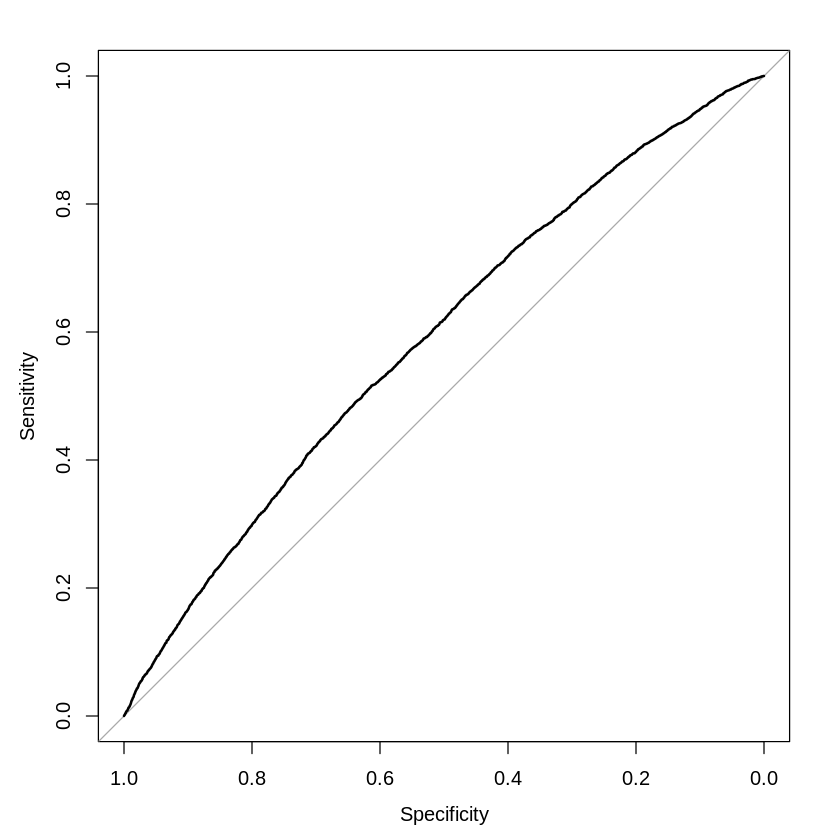

In [ ]:
set.seed(123)
predictions <- predict(Svm_smote_Radial, newdata = SVMtest_data, type = "prob")$Y
# Create a list of thresholds to test
thresholds <- seq(0, 1, by = 0.01)
#Optimal F1 Score Threshold Determination
calculate_f1 <- function(threshold) {
  predicted_classes <- ifelse(predictions >= threshold, "Y", "N")
  confusion <- confusionMatrix(factor(predicted_classes), factor(SVMtest_data$TARGET), positive = "Y")
  # get percision from our confusion matrix
  precision <- confusion$byClass['Pos Pred Value']
  # recall
  recall <- confusion$byClass['Sensitivity']
  # calculating f1 score from percision and recall
  f1_score <- 2 * (precision * recall) / (precision + recall)
  return(f1_score)
}

# Calculate F1-scores for all thresholds
f1_scores <- sapply(thresholds, calculate_f1)

# Get max f1_score
optimal_threshold <- thresholds[which.max(f1_scores)]
print(optimal_threshold)

#use optimal f1_score for our predictions
binary_predictions <- ifelse(predictions > optimal_threshold, "Y", "N")

## Assuming you have the true labels and predicted probabilities:
true_labels <- SVMtest_data$TARGET
predicted_probs <- predictions

# Create the ROC curve object
roc_obj <- roc(true_labels, predictions)

# Plot the precision-recall curve
plot(roc_obj, print.auc = FALSE)

#run and output confusion matrix
confusion <- confusionMatrix(factor(binary_predictions), factor(SVMtest_data$TARGET), positive = "Y")
print(confusion)

# get percision from our confusion matrix
precision <- confusion$byClass['Pos Pred Value']
cat('\nPercision: ', precision)

# recall
recall <- confusion$byClass['Sensitivity']
cat('\nRecall: ', recall)

# calculating f1 score from percision and recall
f1_score <- 2 * (precision * recall) / (precision + recall)
cat("\nF1 Score: ", round(f1_score,4))

After running the model, we see a slight improvement in F1 Score and an increased recall and percision from our linear model. This improvement is a result of our careful model tuning, including the use of a non-linear SVM, a 10:1 weighting of "Y" to "N" observations, and the optimization of the classification threshold. Our accuracy also improved without classifying too many observations into the no-default category. Finally, we print the ROC curve to see the relationship between specificity (True Negative Rate) and sensitivity  (True Positive Rate). Ideally, the curve should hug the top left of the chart, indicating a both high true positive and negatives rates at different thresholds. While our ROC curve does not hug the top left, it does rise above the perfectly linear reference line for a random walk, meaning the model found some patterns in the data, even if they were just slightly above random.

## Test Data

Now we will see how our best performing model, the SVMRadial Model with weighting and smote, performs on our test data.

In [ ]:
#ensure datatypes are correct
SVMTestData <- data.frame(lapply(SVMTestData, function(x) {
  if (is.character(x)) {
    print(x)
  } else {
    x
  }
}))

In [ ]:
#get predictions with kaggle
predictions_final_SVM <- predict(Svm_smote_Radial, newdata = SVMTestData, type = "prob")$Y
# Load sample submission file
sample_submission <- read.csv("/content/sample_submission.csv")

# Add predictions to the sample submission
sample_submission$TARGET <- predictions_final_SVM

# Save the updated submission file
write.csv(sample_submission, "/content/sample_Submission_SVM.csv", row.names = FALSE)



## SVM Conclusions

Unfortuantely, it would seem that perhaps an SVM model is not best suited for modeling the data. While we were able to extract some patterns from the data with our final smote-using-weighted-Radial model, we were only able to achieve an F1 Score of 0.19, meaning that the model is struggling with distinguishing default observations from non-default observations.  Even so, a Kaggle score of 0.58 indicates that the model does perform better than what may be expected through random guessing.

# Linear Regression


In [ ]:
# Load necessary packages
install.packages(c('rminer', 'rpart', 'matrixStats','ranger') )
library(dplyr)
library(ranger)
library(rpart)
library(caret)
library(rminer)
library(matrixStats)
library(knitr)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘XML’, ‘TH.data’, ‘rgl’, ‘rlist’, ‘gtools’, ‘libcoin’, ‘multcomp’, ‘igraph’, ‘doParallel’, ‘ConsRank’, ‘mvtnorm’, ‘modeltools’, ‘strucchange’, ‘coin’, ‘zoo’, ‘sandwich’, ‘plotrix’, ‘kknn’, ‘pls’, ‘mda’, ‘randomForest’, ‘adabag’, ‘party’, ‘Cubist’, ‘glmnet’, ‘xgboost’



Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count




## Clean Train and Test Data for LR

In [ ]:
# Function to clean data - specific to linear regression
set.seed(123)
clean_data3 <- function(data) {
  print(nrow(data))
  # Get list of all factor columns
  factor_cols <- names(data)[sapply(data, is.factor)]
  # Replace the null values with a value of "missing"
  data[factor_cols][is.na(data[factor_cols])] <- "missing"
  data$isCashLoan <- ifelse(data$NAME_CONTRACT_TYPE %in% c("Cash loans"), 1, 0)
  # Convert married to new column that includes 1 if in married or civil marriage and 0 otherwise
  data$isMarried <- ifelse(data$NAME_FAMILY_STATUS %in% c("Married", "Civil marriage"), 1, 0)
  # Creating variable for more than secondary education
  data$morethanSecondaryEd <- ifelse(data$NAME_EDUCATION_TYPE %in% c("Higher education", "Incomplete higher", "Academic degree"), 1, 0)
  # Creating variable for secondary or lower education
  data$SecondaryorLowerEd <- ifelse(data$NAME_EDUCATION_TYPE %in% c("Secondary / secondary special", "Lower secondary"), 1, 0)
  #making factor column for isCashLoan
  # Create an anomalous group - where days employed exceeds 100 years
  data$DAY_EMPLOYED_ANOM <- ifelse(data$DAYS_EMPLOYED >= 36500, 1, 0)
  # Remove the anomalous groups from the data
  data$DAYS_EMPLOYED[data$DAYS_EMPLOYED > 36500] <- NA
  # Create column for years old instead of days old for readability
  data$YearsOld <- data$DAYS_BIRTH / -365
 # Set fixed age bins (for example: from 20 to 80 in 10-year intervals)
  age_bins <- seq(10, 100, by = 10)
  data$age_group <- cut(data$YearsOld, breaks = age_bins, right = FALSE, include.lowest = TRUE, labels = FALSE)

  return(data)
}

# Clean train and test data

cleanedTrainData <- clean_data3(train_data)
cleanedTestData <- clean_data3(test_data)
cleanedTestData1 <- clean_data3(test_data)

allTrain <- clean_data(train_data)

# Split training data into training and validation sets
trainIndex <- createDataPartition(cleanedTrainData$TARGET, p = 0.8, list = FALSE)
trainSet <- cleanedTrainData[trainIndex, ]
testSet <- cleanedTrainData[-trainIndex, ]

cleanedTrainData <- trainSet
cleanedTestData <- testSet

trainTarget <- trainSet$TARGET
testTarget <- testSet$TARGET

[1] 307511
[1] 48744
[1] 48744
 [1] "NAME_CONTRACT_TYPE"         "CODE_GENDER"               
 [3] "FLAG_OWN_CAR"               "FLAG_OWN_REALTY"           
 [5] "NAME_TYPE_SUITE"            "NAME_INCOME_TYPE"          
 [7] "NAME_EDUCATION_TYPE"        "NAME_FAMILY_STATUS"        
 [9] "NAME_HOUSING_TYPE"          "OCCUPATION_TYPE"           
[11] "WEEKDAY_APPR_PROCESS_START" "ORGANIZATION_TYPE"         
[13] "FONDKAPREMONT_MODE"         "HOUSETYPE_MODE"            
[15] "WALLSMATERIAL_MODE"         "EMERGENCYSTATE_MODE"       


## Impute missing data in both train and test datasets

---



In [ ]:
# Impute train data
missing_counts <- colSums(is.na(cleanedTrainData))
missing_columns <- names(missing_counts[missing_counts > 0])

for (col in missing_columns) {
  if (is.numeric(cleanedTrainData[[col]])) {
    cleanedTrainData[[col]][is.na(cleanedTrainData[[col]])] <- mean(cleanedTrainData[[col]], na.rm = TRUE)
  } else {
    print(paste("Column", col, "is not numeric; skipping imputation."))
  }
}
for (col in missing_columns) {
  if (is.factor(cleanedTrainData[[col]]) || is.character(cleanedTrainData[[col]])) {
    mode_value <- as.character(names(sort(table(cleanedTrainData[[col]]), decreasing = TRUE)[1]))
    cleanedTrainData[[col]][is.na(cleanedTrainData[[col]])] <- mode_value
  }
}

for (col in missing_columns) {
  cleanedTrainData[[col]][is.na(cleanedTrainData[[col]])] <- mean(cleanedTrainData[[col]], na.rm = TRUE)
}

In [ ]:
# Impute test data
missing_counts <- colSums(is.na(cleanedTestData))
missing_columns <- names(missing_counts[missing_counts > 0])

for (col in missing_columns) {
  if (is.numeric(cleanedTestData[[col]])) {
    cleanedTestData[[col]][is.na(cleanedTestData[[col]])] <- mean(cleanedTestData[[col]], na.rm = TRUE)
  } else {
    print(paste("Column", col, "is not numeric; skipping imputation."))
  }
}
for (col in missing_columns) {
  if (is.factor(cleanedTestData[[col]]) || is.character(cleanedTestData[[col]])) {
    mode_value <- as.character(names(sort(table(cleanedTestData[[col]]), decreasing = TRUE)[1]))
    cleanedTestData[[col]][is.na(cleanedTestData[[col]])] <- mode_value
  }
}

for (col in missing_columns) {
  cleanedTestData[[col]][is.na(cleanedTestData[[col]])] <- mean(cleanedTestData[[col]], na.rm = TRUE)
}

In [ ]:
# Impute test data
missing_counts <- colSums(is.na(cleanedTestData1))
missing_columns <- names(missing_counts[missing_counts > 0])

for (col in missing_columns) {
  if (is.numeric(cleanedTestData1[[col]])) {
    cleanedTestData1[[col]][is.na(cleanedTestData1[[col]])] <- mean(cleanedTestData1[[col]], na.rm = TRUE)
  } else {
    print(paste("Column", col, "is not numeric; skipping imputation."))
  }
}
for (col in missing_columns) {
  if (is.factor(cleanedTestData1[[col]]) || is.character(cleanedTestData1[[col]])) {
    mode_value <- as.character(names(sort(table(cleanedTestData1[[col]]), decreasing = TRUE)[1]))
    cleanedTestData1[[col]][is.na(cleanedTestData1[[col]])] <- mode_value
  }
}

for (col in missing_columns) {
  cleanedTestData1[[col]][is.na(cleanedTestData1[[col]])] <- mean(cleanedTestData1[[col]], na.rm = TRUE)
}

## Run Linear Regression Models

In [ ]:
# Run a basic logistic regression
base_model = lm(TARGET ~ ., data = cleanedTrainData)

# Run an rpart model
rpart_model = rpart(TARGET ~ ., data = cleanedTrainData)

# Run a glm
glm_model = glm(TARGET ~ ., data = cleanedTrainData, family = binomial)


*Three* linear regression models were created to determine which test is the best predictor for the target. A base linear model was run along with an rpart model and a glm model. The results are below.

## Generate each model's evaluation metrics (MAE, RMSE, MAPE, RMSPE, RAE, RRSE, R2) for test and training



In [ ]:
# lm model
# Generate predictions
predictions_base_train <- predict(base_model, cleanedTrainData)
predictions_base_test <- predict(base_model, cleanedTestData)
# Metrics on train data
mmetric(trainTarget,predictions_base_train,c("MAE","RMSE","MAPE","RMSPE","RAE", "RRSE", "COR", "R2"))
# Metrics on test data
mmetric(testTarget,predictions_base_test,c("MAE","RMSE","MAPE","RMSPE","RAE", "RRSE", "COR", "R2"))


MAE        RMSE        MAPE       RMSPE         RAE        RRSE 
 0.14528242  0.26371284         Inf         Inf 97.76265243 96.74448784 
        COR          R2 
 0.25308182  0.06405041

MAE        RMSE        MAPE       RMSPE         RAE        RRSE 
 0.14506650  0.26300759         Inf         Inf 98.22553946 96.78586003 
        COR          R2 
 0.25152508  0.06326486

In [ ]:
# rpart model
# Generate predictions using the model tree
predictions_rpart_train <- predict(rpart_model, cleanedTrainData)
predictions_rpart_test <- predict(rpart_model, cleanedTestData)
# Metrics on train data
mmetric(trainTarget,predictions_rpart_train,c("MAE","RMSE","MAPE","RMSPE","RAE", "RRSE","COR", "R2"))
# Metrics on test data
mmetric(testTarget,predictions_rpart_test,c("MAE","RMSE","MAPE","RMSPE","RAE", "RRSE","COR", "R2"))


MAE        RMSE        MAPE       RMSPE         RAE        RRSE 
 0.14436987  0.26867254         Inf         Inf 97.14858239 98.56398044 
        COR          R2 
 0.16886141  0.02851418

MAE        RMSE        MAPE       RMSPE         RAE        RRSE 
 0.14388268  0.26785639         Inf         Inf 97.42396825 98.57020363 
        COR          R2 
 0.16850716  0.02839466

In [ ]:
# GLM model
# Generate predictions using the model tree
predictions_glm_train <- predict(glm_model, cleanedTrainData)
predictions_glm_test <- predict(glm_model, cleanedTestData)
# Metrics on train data
mmetric(trainTarget,predictions_glm_train,c("MAE","RMSE","MAPE","RMSPE","RAE","RRSE","COR","R2"))
# Metrics on test data
mmetric(testTarget,predictions_glm_test,c("MAE","RMSE","MAPE","RMSPE","RAE","RRSE","COR","R2"))


MAE         RMSE         MAPE        RMSPE          RAE         RRSE 
2.876952e+00 3.024283e+00          Inf          Inf 1.935943e+03 1.109475e+03 
         COR           R2 
2.480416e-01 6.152466e-02

MAE         RMSE         MAPE        RMSPE          RAE         RRSE 
2.873319e+00 3.021362e+00          Inf          Inf 1.945544e+03 1.111851e+03 
         COR           R2 
2.468189e-01 6.091959e-02

The lm and rpart models produced very similar metrics. A low RMSE is a good indicator that these models are doing a good job of predicting the target variable, and in both cases the RMSE is 0.26. However, the model's relative absolute error is quite high, indicating that the models error levels are much higher than the baseline. The GLM had a very high RMSE and RAE, and had the worst metrics of all models tested. The R-squared value for the lm model was 0.06 and for the rpart model was 0.02. These are extremely low values, meaning that only 2% or 6% of the variance is explained by these models, respectively. This suggests poor model performance in terms of prediction accuracy and fit. This leads to the conclusion that a linear model would not be the best fit for this data, but this will be checked after a cross-validation is run.

## Run a Cross-validation

> Add blockquote



A cross validation function is created below to validate the models run above.

In [ ]:
# cross validation function
cv_function <- function(df, target, nFolds, seedVal, prediction_method, metrics_list)
{
  # Create folds
  set.seed(seedVal)
  folds = createFolds(df[,target],nFolds)

  # Perform cross validation
  cv_results <- lapply(folds, function(x)
  {
    test_target <- df[x,target]
    test_input  <- df[x,-target]

    train_target <- df[-x,target]
    train_input <- df[-x,-target]

    prediction_model <- prediction_method(train_target~.,train_input)
    pred <- predict(prediction_model,test_input)
    return(mmetric(test_target,pred,metrics_list))
  })

  # Generate means and sds and show cv results, means and sds using kable
  cv_results_m <- as.matrix(as.data.frame(cv_results))
  cv_mean<- as.matrix(rowMeans(cv_results_m))
  cv_sd <- as.matrix(rowSds(cv_results_m))
  colnames(cv_mean) <- "Mean"
  colnames(cv_sd) <- "Sd"
  cv_all <- cbind(cv_results_m, cv_mean, cv_sd)
  kable(t(cv_all),digits=2)
}

In [ ]:
df <- allTrain
target <- 8
nFolds <- 5
seedVal <- 123
metrics_list <- c("MAE","RMSE","MAPE","RMSPE","RAE","RRSE","R2")

library(matrixStats)
library(knitr)

# lm
assign("prediction_method", lm)
cv_function(df, target, nFolds, seedVal, prediction_method, metrics_list)

# rpart
assign("prediction_method", rpart)
cv_function(df, target, nFolds, seedVal, prediction_method, metrics_list)

# GLM
assign("prediction_method", glm)
cv_function(df, target, nFolds, seedVal, prediction_method, metrics_list)

ERROR: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]): contrasts can be applied only to factors with 2 or more levels


Unfortunately, the cross validation function will not run with the lm and GLM functions. We are able to see from the rpart cross validation that the results of the cross validation are consistent with those of the model predictions and evaluations. The RMSE is quite large, meaning the error rate is high. The relative absolute error is slightly lower in the cross evaluation than the initial predictions, however it is still quite high. The R-squared value dropped to 0.01, meaning only 1% of variance is explained in the mode. This leads to the conclusion that a linear regression model is not a good fit for predicting the target for the home credit default risk.


## Kaggle Score for Linear Regression

In [ ]:
glm_preds <- predict(glm_model, cleanedTestData1, type="response")

In [ ]:

#binary_predictions_final_SVM <- ifelse(predictions_final_SVM > optimal_threshold, "Y", "N")

# Load sample submission file
sample_submission <- read.csv("/content/sample_submission.csv")

# Add predictions to the sample submission
sample_submission$TARGET <- glm_preds

# Save the updated submission file
write.csv(sample_submission, "/content/sample_Submission_LinearModel.csv", row.names = FALSE)



The returned Kaggle score for linear regression was approximately 0.73. This places the Linear Regression at nearly the same level as the LightGBM model, but allows for quicker fitting of the training data. This could indicate that a linear regression model may be optimal in some use cases, despit its slightly lower score.